<a href="https://colab.research.google.com/github/m-samhitha/Parkinson-s-Disease-Detection-using-Vocal-Features/blob/main/Parkinsons_Disease_Detection_using_Vocal_Features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Found 144 images belonging to 2 classes.
Found 60 images belonging to 2 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 114s 19s/step - accuracy: 0.4900 - loss: 1.1124 - val_accuracy: 0.6000 - val_loss: 0.6746 - learning_rate: 1.0000e-04
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 49s 10s/step - accuracy: 0.4313 - loss: 1.0635 - val_accuracy: 0.6833 - val_loss: 0.6451 - learning_rate: 1.0000e-04
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.6199 - loss: 0.8582 - val_accuracy: 0.7333 - val_loss: 0.6162 - learning_rate: 1.0000e-04
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 11s/step - accuracy: 0.6350 - loss: 0.6557 - val_accuracy: 0.7500 - val_loss: 0.5887 - learning_rate: 1.0000e-04
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.6718 - loss: 0.6419 - val_accuracy: 0.7500 - val_loss: 0.5669 - learning_rate: 1.0000e-04
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 10s/step - accuracy: 0.6260 - loss: 0.7497 - val_accuracy: 0.7667 - val_loss: 0.5502 - learning_rate: 1.0000e-04
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 50s 10s/step - accuracy: 0.7812 - loss: 0.570

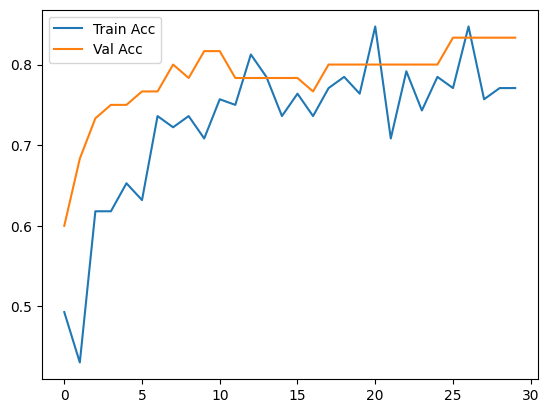

In [ ]:
# ============================================
# Parkinson's Disease Detection - DenseNet201
# ============================================

# STEP 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 2: Import Libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# STEP 3: Dataset Path
base_dir = "/content/drive/MyDrive/Parkinsons"

train_dir = base_dir + "/training"
test_dir = base_dir + "/testing"

# STEP 4: Data Generators with Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode="binary",
    shuffle=False
)

# STEP 5: Load Pretrained DenseNet201
base_model = DenseNet201(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze initial layers

# STEP 6: Build Model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=predictions)

# STEP 7: Compile Model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# STEP 8: Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.3, patience=3, verbose=1)
]

# STEP 9: Train Initial Model
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=20,
    callbacks=callbacks
)

# STEP 10: Fine-tuning (unfreeze last layers)
base_model.trainable = True
for layer in base_model.layers[:-30]:   # unfreeze last 30 layers
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5),
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_finetune = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=10,
    callbacks=callbacks
)

# STEP 11: Evaluate
loss, acc = model.evaluate(test_generator)
print(f"✅ Final Test Accuracy: {acc*100:.2f}%")

# STEP 12: Plot Training Curves
plt.plot(history.history['accuracy'] + history_finetune.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'] + history_finetune.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 16s/step


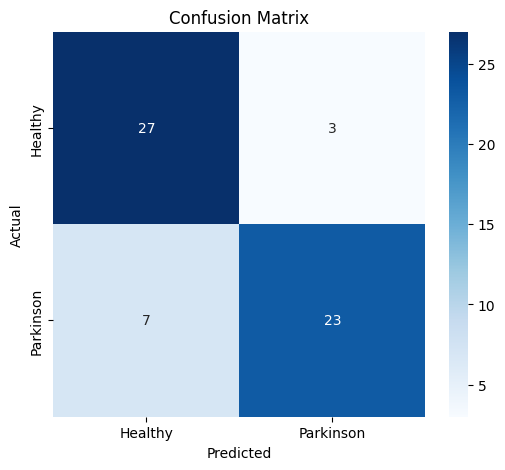

Classification Report:

              precision    recall  f1-score   support

     Healthy       0.79      0.90      0.84        30
   Parkinson       0.88      0.77      0.82        30

    accuracy                           0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60



In [ ]:
# STEP 13: Confusion Matrix & Classification Report
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = (y_pred > 0.5).astype("int32").flatten()
y_true = test_generator.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Healthy", "Parkinson"],
            yticklabels=["Healthy", "Parkinson"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("Classification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=["Healthy", "Parkinson"]))
